# SQL Database Pipeline #

In [4]:
import os
import pandas as pd
import sqlite3
from fredapi import Fred

# --- 1️⃣ Set Up API Key ---
FRED_API_KEY = "your_api_key"  # Replace with your actual key
fred = Fred(api_key=FRED_API_KEY)

# --- 2️⃣ Define Treasury Yield Series ---
FRED_SERIES = {
    "T1M": "DGS1MO",
    "T3M": "DGS3MO",
    "T6M": "DGS6MO",
    "T1Y": "DGS1",
    "T2Y": "DGS2",
    "T5Y": "DGS5",
    "T10Y": "DGS10",
    "T30Y": "DGS30",
}

# --- 3️⃣ Create a Folder for CSVs ---
csv_folder = "treasury_data"
os.makedirs(csv_folder, exist_ok=True)  # Create folder if not exists

# --- 4️⃣ Fetch Data and Save Each Maturity as CSV ---
for maturity, series_id in FRED_SERIES.items():
    df = fred.get_series(series_id).reset_index()
    df.columns = ["date", "yield"]  # Standardize column names
    df["date"] = df["date"].astype(str)  # Ensure date is string for SQLite
    file_path = os.path.join(csv_folder, f"{maturity}_Treasury.csv")
    df.to_csv(file_path, index=False)
    print(f"Saved {maturity} data to {file_path}")

Saved T1M data to treasury_data/T1M_Treasury.csv
Saved T3M data to treasury_data/T3M_Treasury.csv
Saved T6M data to treasury_data/T6M_Treasury.csv
Saved T1Y data to treasury_data/T1Y_Treasury.csv
Saved T2Y data to treasury_data/T2Y_Treasury.csv
Saved T5Y data to treasury_data/T5Y_Treasury.csv
Saved T10Y data to treasury_data/T10Y_Treasury.csv
Saved T30Y data to treasury_data/T30Y_Treasury.csv


In [7]:
# --- 5️⃣ Connect to SQLite Database ---
db_path = "yields.db"
conn = sqlite3.connect(db_path)
cursor = conn.cursor()

# --- 6️⃣ Drop Table If Needed (Optional - For Debugging) ---
cursor.execute("DROP TABLE IF EXISTS BondYields")

# --- 7️⃣ Create `BondYields` Table with All Maturities ---
columns = ["date TEXT PRIMARY KEY"] + [f"{maturity} REAL" for maturity in FRED_SERIES.keys()]
cursor.execute(f"""
    CREATE TABLE BondYields (
        {', '.join(columns)}
    )
""")
conn.commit()

# --- 8️⃣ Import CSVs into SQLite Database ---
csv_files = glob.glob(os.path.join(csv_folder, "*_Treasury.csv"))

for file in csv_files:
    maturity = os.path.basename(file).split("_")[0]
    df = pd.read_csv(file)
    df = df.rename(columns={"yield": maturity})  # Rename yield column
    df["date"] = pd.to_datetime(df["date"]).dt.strftime("%Y-%m-%d")

    # Insert new rows into BondYields
    for _, row in df.iterrows():
        cursor.execute(f"""
            INSERT OR IGNORE INTO BondYields (date) VALUES (?)
        """, (row["date"],))

        cursor.execute(f"""
            UPDATE BondYields
            SET {maturity} = ?
            WHERE date = ?
        """, (row[maturity], row["date"]))

conn.commit()

# --- 9️⃣ Optimize Performance ---
cursor.execute("CREATE INDEX IF NOT EXISTS idx_date ON BondYields(date);")
conn.commit()

# --- 🔟 Close the Database Connection ---
conn.close()
print("Database update complete.")

Database update complete.


In [10]:
# --- 9️⃣ Load and Melt the Data ---
conn = sqlite3.connect(db_path)

# Load the BondYields table
df = pd.read_sql("SELECT * FROM BondYields", conn)

# Melt into long format
melted_df = df.melt(id_vars=["date"], var_name="maturity", value_name="yield")

melted_df = melted_df.dropna()

# Display the DataFrame (Choose one method)
display(melted_df)  # Works in Jupyter Notebook
# print(melted_df.head())  # Use this for terminal output
# melted_df.to_csv("melted_yield_data.csv", index=False)  # Save to CSV

conn.close()

,date,maturity,yield
6380,2001-07-31,T1M,3.67
6381,2001-08-01,T1M,3.65
6382,2001-08-02,T1M,3.65
6383,2001-08-03,T1M,3.63
6384,2001-08-06,T1M,3.62
...,...,...,...
127746,2025-01-30,T30Y,4.76
127747,2025-01-31,T30Y,4.83
127748,2025-02-03,T30Y,4.77
127749,2025-02-04,T30Y,4.75


In [32]:
with sqlite3.connect("yields.db") as conn:
    df = pd.read_sql_query('SELECT * FROM BondYields;', conn)
    df = df.dropna()
    df = df.melt(id_vars=["date"], var_name="maturity", value_name="yield")
df

,date,maturity,yield
0,2001-07-31,T1M,3.67
1,2001-08-01,T1M,3.65
2,2001-08-02,T1M,3.65
3,2001-08-03,T1M,3.63
4,2001-08-06,T1M,3.62
...,...,...,...
47043,2025-01-30,T30Y,4.76
47044,2025-01-31,T30Y,4.83
47045,2025-02-03,T30Y,4.77
47046,2025-02-04,T30Y,4.75


In [25]:
import plotly.express as px

In [33]:
def query_yield_curve(db_file, start_date, end_date):
    conn = sqlite3.connect(db_file)
    
    # Writes the SQL query using f-strings
    query = f"""
        SELECT *
        FROM BondYields
        WHERE date BETWEEN '{start_date}' AND '{end_date}'
    """
    
    df=pd.read_sql_query(query, conn)
    df = df.dropna()
    df = df.melt(id_vars=["date"], var_name="maturity", value_name="yield")
    conn.close()
    
    return df

In [34]:
def plot_yields(db_file, start_date, end_date):
    
    df = query_yield_curve(db_file, start_date, end_date)
    
    fig = px.line(df, x="maturity", y="yield", color="date",
                  title=f"Treasury Yield Curve ({start_date} to {end_date})",
                  labels={"maturity": "Maturity", "yield": "Yield (%)"},
                  markers=True)
    
    return fig

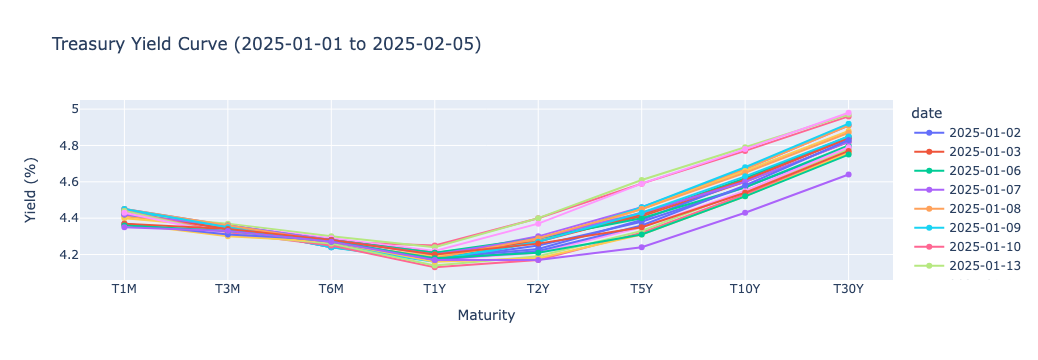

In [38]:
fig = plot_yields(db_file = "yields.db",
            start_date = "2025-01-01",
            end_date = "2025-02-05")

fig.show()